In [1]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Итоговое задание по Проект 3. О вкусной и здоровой пище

***
### Импорт библиотек

In [3]:
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
from sklearn.model_selection import train_test_split # Загружаем специальный инструмент для разбивки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

### Импорт данных

In [4]:
pd.set_option('display.max_columns', 200)
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
display(df_train.head(2))
display(df_test.head(2))

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944


In [5]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [6]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Sample'] = 1 # помечаем где у нас трейн
df_test['Sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Sample,Rating
29266,id_798,Amsterdam,"['Bar', 'Pub', 'Dutch', 'European']",800.0,$$ - $$$,61.0,"[['Best craft beer bar in Amsterdam', 'One of ...",/Restaurant_Review-g188590-d3349387-Reviews-Ca...,d3349387,1,4.5
39988,id_359,Zurich,"['Indian', 'Asian', 'Vegetarian Friendly', 'Ve...",361.0,$$ - $$$,128.0,"[['Nice Dinner, friendly Service and comforta....",/Restaurant_Review-g188113-d1443491-Reviews-Ta...,d1443491,1,4.0
1940,id_1940,Paris,['Chinese'],4881.0,$$ - $$$,18.0,"[['Food is Fantastic and Big Portion', 'Betwee...",/Restaurant_Review-g187147-d11014392-Reviews-S...,d11014392,0,0.0
10049,id_1048,Paris,"['French', 'European', 'Vegetarian Friendly']",1049.0,$$$$,281.0,"[['Amazing French cuisine', 'One of our best m...",/Restaurant_Review-g187147-d719083-Reviews-Le_...,d719083,1,4.5
35034,id_1890,Amsterdam,NaN,1895.0,NaN,10.0,[['No Jelly Donuts available; only special or....,/Restaurant_Review-g188590-d12367475-Reviews-D...,d12367475,1,4.0


In [7]:
df.columns = ['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range',
       'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'Sample', 'Rating']

## Детальный анализ по переменным
***

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine_Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price_Range        32639 non-null  object 
 5   Number_of_Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   Sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


### 1. Restaurant_id 
##### — идентификационный номер ресторана / сети ресторанов;

In [9]:
df['Restaurant_id'] = df['Restaurant_id'].apply(lambda x: float(x[3:]))
df.head(3)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,Sample,Rating
0,0.0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,1.0,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,2.0,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0


#### Переменная Restaurant_id
Преобразован идентификационный номер ресторана в числовое значение.\
Визуально видно, что данный признак схож с признаком Ranking.\
Пока что оставим его, но впоследствии проверим их корреляцию.

### 2. City
##### — город, в котором находится ресторан;

Введем признак столичного расположения ресторана

In [10]:
print(f'Количество городов в датасете - {len(df.City.unique())}')
print(df.City.unique())

Количество городов в датасете - 31
['Paris' 'Helsinki' 'Edinburgh' 'London' 'Bratislava' 'Lisbon' 'Budapest'
 'Stockholm' 'Rome' 'Milan' 'Munich' 'Hamburg' 'Prague' 'Vienna' 'Dublin'
 'Barcelona' 'Brussels' 'Madrid' 'Oslo' 'Amsterdam' 'Berlin' 'Lyon'
 'Athens' 'Warsaw' 'Oporto' 'Krakow' 'Copenhagen' 'Luxembourg' 'Zurich'
 'Geneva' 'Ljubljana']


Введем признак столичного расположения ресторана

In [11]:
not_capital = ["Krakow", "Lyon","Zurich","Hamburg","Barcelona","Oporto","Munich","Milan","Geneva"]

In [12]:
capital_rest=[]
other_city_rest=[]
for i in df['City']:
    if i in not_capital:
        other_city_rest.append(i)
    else:
        capital_rest.append(i)
        
print(f'Количество ресторанов в столицах:{len(capital_rest)}')
print(f'Количество остальных ресторанов :{len(other_city_rest)}')

Количество ресторанов в столицах:37983
Количество остальных ресторанов :12017


In [13]:
df['Capital_restaurant']=df['City'].apply(lambda x: 0 if x in not_capital else 1)
df[['Capital_restaurant']].sample(5)

,Capital_restaurant
3766,1
43228,1
21950,0
34653,0
28569,1


Переведем признак City в dummy-переменные

In [14]:
df_City_dummies = pd.get_dummies(df['City'], dummy_na=False).astype('float64')
df = pd.concat([df,df_City_dummies], axis=1)

#### Переменная City
Без пропусков, категориальный признак.
Сгенерированы новые признаки города по типу dummies.\
А также численный признак столичного расположения ресторана - Capital_restaurant.

### 3. Cuisine_Style
##### — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

In [15]:
display((pd.isna(df['Cuisine_Style']).astype('float64')).value_counts())

0.0    38410
1.0    11590
Name: Cuisine_Style, dtype: int64

In [16]:
# проведем обработку значений переменной
df['Cuisine_Style']= df['Cuisine_Style'].str.replace(r'[\[\]\']','')
# заполним пропуски значением 'Unspecified'
df['Cuisine_Style'] = df['Cuisine_Style'].fillna('Unspecified')
#посчитаем количество кухонь в каждом ресторане
df['Сount_Сuisine'] = df.Cuisine_Style.apply(lambda x: len(x.split(',')))

Переменная Cuisine_Style
11590 пропусков, заменим их на значение - 'Unspecified'.\
Сгенерирован новый признак количества кухонь в каждом ресторане - 'Сount_Сuisine'

### 4. Ranking
##### — место, которое занимает данный ресторан среди всех ресторанов своего города;

In [17]:
df.Ranking.describe()

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

In [18]:
df[['Restaurant_id','Ranking']].corr()

,Restaurant_id,Ranking
Restaurant_id,1.00000,0.82509
Ranking,0.82509,1.00000


In [19]:
df = df.drop(['Restaurant_id'], axis=1)

#### Переменная Ranking
Без пропусков. Почти полностью скоррелирована с Restaurant_id.\
На мой взгялд Restaurant_id можно удалить

Попробуем также выяснить, как население городов влияет на место,\
которое занимает данный ресторан среди всех ресторанов своего города.\
Для этого необходимо ввести данные о количестве населения.

In [20]:
Сity_population= {'London' : 8539, 'Paris' : 2197, 'Madrid' : 3222, 'Barcelona' : 1621, 
                        'Berlin' : 3723, 'Milan' : 1342, 'Rome' : 2869, 'Prague' : 1281, 
                        'Lisbon' : 506, 'Vienna' : 1889, 'Amsterdam' : 866, 'Brussels' : 179, 
                        'Hamburg' : 1718, 'Munich' : 1450, 'Lyon' : 516, 'Stockholm' : 961, 
                        'Budapest' : 1745, 'Warsaw' : 1790, 'Dublin' : 554, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 402, 'Oporto' : 249, 'Geneva' : 184, 'Krakow' : 755, 
                        'Oslo' : 693, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 120, 'Ljubljana' : 284}
df['Сity_population'] = df.apply(lambda row: Сity_population[row['City']], axis = 1)

Мы также отнормируем данный признак и внесем его в датасет

In [21]:
mean_Ranking_on_City = df.groupby(['City'])['Ranking'].mean()
df['mean_Ranking_on_City'] = df.City.map(mean_Ranking_on_City)
df['norm_Ranking_on_Popul_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['Сity_population']

### 5. Price_Range
##### — диапазон цен в ресторане;

In [22]:
display(pd.isna(df['Price_Range']).astype('float64').value_counts())

0.0    32639
1.0    17361
Name: Price_Range, dtype: int64

In [23]:
df['Price_Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price_Range, dtype: int64

In [24]:
df.loc[df['Price_Range'] == '$$$$', ['Price_Range']] = 3
df.loc[df['Price_Range'] == '$$ - $$$', ['Price_Range']] = 2
df.loc[df['Price_Range'] == '$', ['Price_Range']] = 1
df['Price_Range'] = df['Price_Range'].fillna(2)
df['Price_Range'].value_counts()

2    40402
1     7816
3     1782
Name: Price_Range, dtype: int64

#### Переменная Price_Range
13886 - пропусков. Был изменен признак с символьного на числовой с сохранением сути значений\
(низкая цена - 1, средняя цена -2 , высокая цена - 3)\
18412 ресторанов имеют средний параметр цены, это 71% из имеющейся информации\
поэтому заполняем пропуски средним значением

### 5. Number of Reviews
#### — количество отзывов о ресторане;

In [25]:
display(pd.isna(df['Number_of_Reviews']).astype('float64').value_counts())

0.0    46800
1.0     3200
Name: Number_of_Reviews, dtype: int64

In [26]:
means1 = df.groupby('City')['Number_of_Reviews'].mean()
df['Number_of_Reviews_means'] = round(df.City.map(means1),0)

In [27]:
df['Number_of_Reviews'] = df['Number_of_Reviews'].fillna(df['Number_of_Reviews'].mean())
df['Number_of_Reviews'].value_counts()

124.471197     3200
2.000000       2403
3.000000       2042
4.000000       1707
5.000000       1471
               ... 
5216.000000       1
1932.000000       1
1050.000000       1
1145.000000       1
1471.000000       1
Name: Number_of_Reviews, Length: 1574, dtype: int64

Переменная Number of Reviews
3200 - пропусков. Оставляем их и заменям средним значением по признаку.\
Сгенерирован новый признак среднего количество отзывов о ресторане по городам - 'Number_of_Reviews_means'.\
Заполним пропуски средним по количеству отзывов

### 6. Reviews
#### — данные о двух отзывах, которые отображаются на сайте ресторана;

In [28]:
df['Reviews'] = df['Reviews'].fillna('[[], []]')
df['Reviews'] = df['Reviews'].str.replace(r'\[\[\], \[\]\]','None')
s = df['Reviews'].str.split(r"'\], \['",expand=True)
s.columns = ['comments','dates']
s1 = s['comments'].str.split(r"', '",expand=True)
s1.columns = ['comment1','comment2']
s2 = s['dates'].str.split(r"', '",expand=True)
s2.columns = ['date1','date2']
s3 = pd.concat([s1,s2],axis=1)
s3.date1 = s3.date1.str.replace(r'[\[\]\']','')
s3.date2 = s3.date2.str.replace(r'[\[\]\']','')
df_new = pd.concat([df,s3],axis=1)

In [29]:
date1null = pd.isna(df_new['date1']).astype('float64')
date2null = pd.isna(df_new['date2']).astype('float64')
df_new['len_comment'] = (1 - date1null) + (1 -date2null)
df_new[['len_comment']].head()

,len_comment
0,0.0
1,2.0
2,2.0
3,2.0
4,2.0


In [30]:
df_new['date1'] = pd.to_datetime(df_new['date1'])
df_new['date2'] = pd.to_datetime(df_new['date2'])
df_new['diff_date']=abs(df_new['date1']-df_new['date2'])
df_new.diff_date = df_new.diff_date.dt.days
df_new.diff_date = df_new.diff_date.fillna(0)

In [31]:
dayspass = df_new['date1'].max()-df_new['date1']
dayspass2 = df_new['date1'].max()-df_new['date2']
df_new['dayspass'] = np.where(dayspass >= dayspass2, dayspass, dayspass2)
df_new['dayspass'] = df_new['dayspass'].fillna(pd.to_timedelta(0))
df_new['dayspass'] = df_new['dayspass'].dt.days

In [32]:
df_new.drop(['Reviews','comment1','comment2','date1','date2'], axis='columns', inplace=True)

#### Переменная Reviews
Пропусков данных нет, каждая ячейка заполнена, но есть 6471 значений '[[], []]'\
И по сути можно расценить их как пропуски.
Были созданы признаки:\
len_comment - кол-во коментариев в отзыве;\
dayspass - насколько давно был сделан последний самый свежий отзыв в днях(на момент получения базы);\
diff_date - перерыв между отзывами в днях;\
Пропуски в данных признаках пока что заменим на 0, так как не удаляем значения из датасета.
Также был убран из основного датасета сам признак Reviews, послуживший донором информации для созданных признаков,\
и были удалены признаки, несущие информацию, полученые из данного признака, поскольку в них больше нет необходимости

In [33]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   City                           50000 non-null  object 
 1   Cuisine_Style                  50000 non-null  object 
 2   Ranking                        50000 non-null  float64
 3   Price_Range                    50000 non-null  int64  
 4   Number_of_Reviews              50000 non-null  float64
 5   URL_TA                         50000 non-null  object 
 6   ID_TA                          50000 non-null  object 
 7   Sample                         50000 non-null  int64  
 8   Rating                         50000 non-null  float64
 9   Capital_restaurant             50000 non-null  int64  
 10  Amsterdam                      50000 non-null  float64
 11  Athens                         50000 non-null  float64
 12  Barcelona                      50000 non-null 

In [34]:
df_new.drop(df_new.select_dtypes(['object']), inplace=True, axis=1)
df_new.head()

,Ranking,Price_Range,Number_of_Reviews,Sample,Rating,Capital_restaurant,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Сount_Сuisine,Сity_population,mean_Ranking_on_City,norm_Ranking_on_Popul_in_City,Number_of_Reviews_means,len_comment,diff_date,dayspass
0,12963.0,2,4.0,0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2197,6938.557138,2.742122,117.0,0.0,0.0,0
1,106.0,2,97.0,0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,643,564.231579,-0.712646,66.0,2.0,37.0,120
2,810.0,2,28.0,0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,513,885.130201,-0.146453,238.0,2.0,22.0,82
3,1669.0,3,202.0,0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,8539,8169.707354,-0.761296,138.0,2.0,14.0,96
4,37.0,3,162.0,0,0.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,426,462.428947,-0.998660,52.0,2.0,15.0,33


In [35]:
df_new.columns

Index(['Ranking', 'Price_Range', 'Number_of_Reviews', 'Sample', 'Rating',
       'Capital_restaurant', 'Amsterdam', 'Athens', 'Barcelona', 'Berlin',
       'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin',
       'Edinburgh', 'Geneva', 'Hamburg', 'Helsinki', 'Krakow', 'Lisbon',
       'Ljubljana', 'London', 'Luxembourg', 'Lyon', 'Madrid', 'Milan',
       'Munich', 'Oporto', 'Oslo', 'Paris', 'Prague', 'Rome', 'Stockholm',
       'Vienna', 'Warsaw', 'Zurich', 'Сount_Сuisine', 'Сity_population',
       'mean_Ranking_on_City', 'norm_Ranking_on_Popul_in_City',
       'Number_of_Reviews_means', 'len_comment', 'diff_date', 'dayspass'],
      dtype='object')

In [36]:
df_new2 = df_new.drop(['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Bratislava', 'Brussels',
       'Budapest', 'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg',
       'Helsinki', 'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg',
       'Lyon', 'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris',
       'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich'],axis = 1)
df_new2

,Ranking,Price_Range,Number_of_Reviews,Sample,Rating,Capital_restaurant,Сount_Сuisine,Сity_population,mean_Ranking_on_City,norm_Ranking_on_Popul_in_City,Number_of_Reviews_means,len_comment,diff_date,dayspass
0,12963.0,2,4.0,0,0.0,1,2,2197,6938.557138,2.742122,117.0,0.0,0.0,0
1,106.0,2,97.0,0,0.0,1,5,643,564.231579,-0.712646,66.0,2.0,37.0,120
2,810.0,2,28.0,0,0.0,1,1,513,885.130201,-0.146453,238.0,2.0,22.0,82
3,1669.0,3,202.0,0,0.0,1,5,8539,8169.707354,-0.761296,138.0,2.0,14.0,96
4,37.0,3,162.0,0,0.0,1,6,426,462.428947,-0.998660,52.0,2.0,15.0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,2,79.0,1,4.5,0,4,1342,3106.027840,-1.941899,168.0,2.0,34.0,106
49996,6341.0,2,542.0,1,3.5,1,5,2197,6938.557138,-0.271988,117.0,2.0,9.0,76
49997,1652.0,2,4.0,1,4.5,1,2,961,1237.482091,0.431340,75.0,2.0,3127.0,3607
49998,641.0,2,70.0,1,4.0,1,5,1790,1055.193514,-0.231393,67.0,2.0,23.0,253


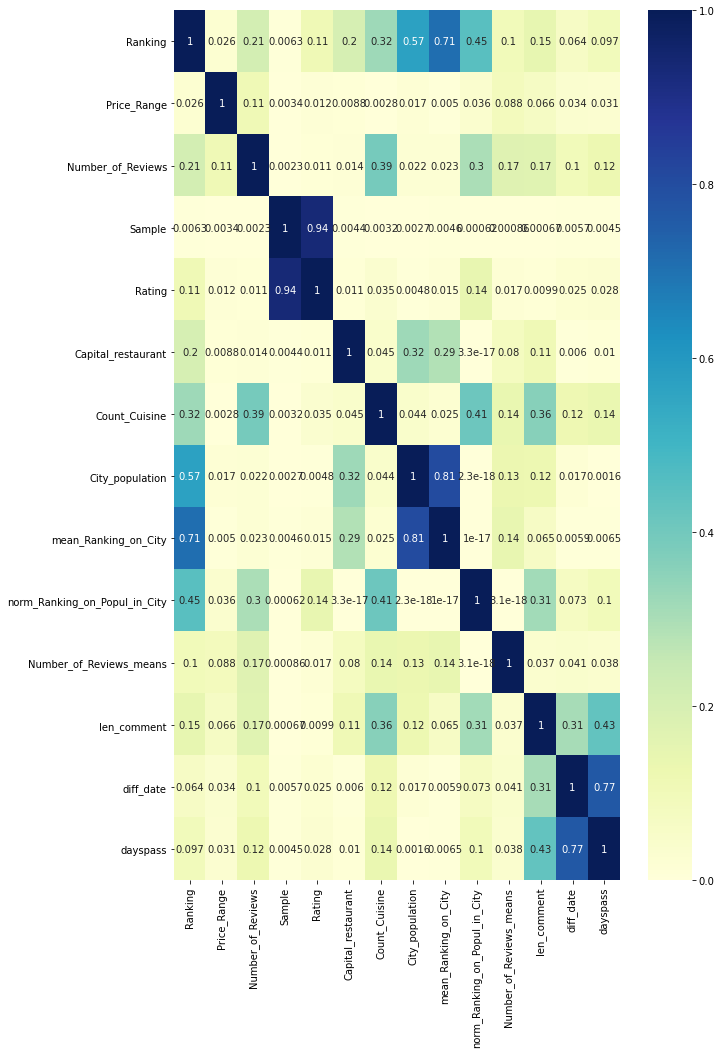

In [37]:
plt.figure(figsize=(10, 16))
sns.heatmap(df_new2.corr().abs(), vmin=0, vmax=1, annot = True, cmap="YlGnBu")

Как мы видим, что относительно сильная корреляция выявлена между двух пар созданных признаков - 'diff_date' и 'dayspass',\
и Сity_population' и 'mean_Ranking_on_City'\
Не будем удалять никаие признаки. 
Выбросы из признаков тоже не удаляем.

# Итог

In [38]:
# Теперь выделим тестовую часть
train_data = df_new.query('Sample == 1').drop(['Sample'], axis=1)
test_data = df_new.query('Sample == 0').drop(['Sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
regr.fit(X_train, y_train)  

y_pred = regr.predict(X_test)    
    
mea = metrics.mean_absolute_error(y_pred, y_test)
print(f'MAE: {round(mea,7)}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s


MAE: 0.207152


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


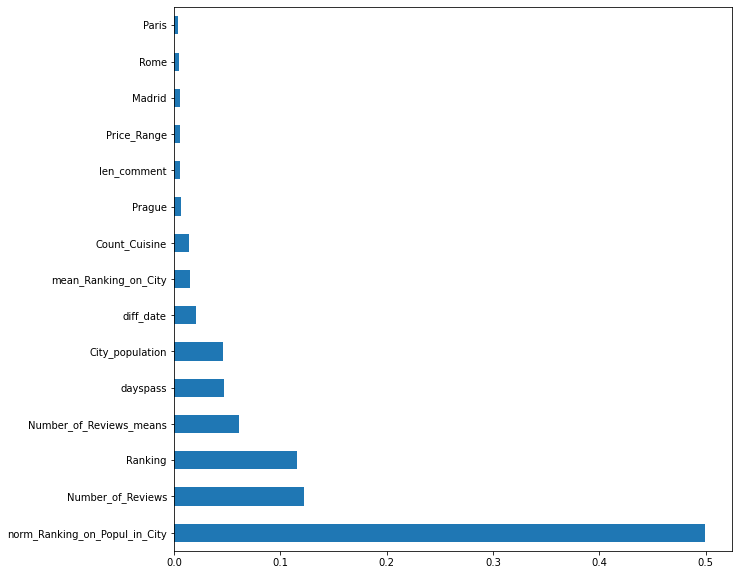

In [40]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Submission

In [41]:
test_data.sample(10)

,Ranking,Price_Range,Number_of_Reviews,Rating,Capital_restaurant,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Сount_Сuisine,Сity_population,mean_Ranking_on_City,norm_Ranking_on_Popul_in_City,Number_of_Reviews_means,len_comment,diff_date,dayspass
2242,3970.0,1,45.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1342,3106.027840,0.643794,168.0,2.0,610.0,941
9098,1108.0,2,204.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1621,3879.422680,-1.709699,136.0,2.0,62.0,116
7821,2435.0,2,225.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,8539,8169.707354,-0.671590,138.0,2.0,9.0,97
5730,12191.0,2,6.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2197,6938.557138,2.390734,117.0,0.0,0.0,0
3148,618.0,3,454.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2197,6938.557138,-2.876904,117.0,2.0,62.0,156
4535,3984.0,1,12.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1342,3106.027840,0.654227,168.0,0.0,0.0,0
3264,2000.0,2,23.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,2869,2970.733102,-0.338352,290.0,0.0,0.0,0
2367,15871.0,1,19.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,8539,8169.707354,0.901896,138.0,2.0,30.0,259
411,7795.0,2,100.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8539,8169.707354,-0.043882,138.0,2.0,10.0,137
8087,8624.0,1,17.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,8539,8169.707354,0.053202,138.0,2.0,110.0,249


In [42]:
test_data = test_data.drop(['Rating'], axis=1)

In [43]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [44]:
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [45]:
predict_submission

array([3.045, 4.205, 4.405, ..., 3.   , 4.01 , 4.29 ])

In [46]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.045
1,id_1,4.205
2,id_2,4.405
3,id_3,4.325
4,id_4,4.420
5,id_5,4.280
6,id_6,1.235
7,id_7,3.075
8,id_8,4.030
9,id_9,4.455
